# STEP 5 — EVALUATION (FOUNDATION-FIRST)

## 🎯 Objective
This notebook serves as the **standardized evaluation hub** for the project. it will:
1.  Define the **metrics** used for all models.
2.  Maintain a **consistent results table**.
3.  Compare models as they are developed.

## 1️⃣ Standard Evaluation Metrics

> **Evaluation Metrics**
> For classification, all models are evaluated using **Accuracy**, **F1-score**, and **ROC-AUC** to ensure fair comparison across algorithms.

These 3 metrics are:
*   **Required** by the assignment.
*   **Suitable** for our potentially imbalanced e-commerce data.
*   **Common** across different model types (Tree, NB, etc.).

## 2️⃣ Results Schema

We define a global list `results` to store metrics for all models.

In [1]:
# Global results list
results = []

def add_result(model_name, accuracy, f1, roc_auc):
    """
    Adds a model's performance metrics to the global results list.
    """
    results.append({
        "model": model_name,
        "accuracy": accuracy,
        "f1_score": f1,
        "roc_auc": roc_auc
    })
    print(f"✅ Added results for: {model_name}")

## 3️⃣ Baseline Model: Decision Tree (Person A)

We load the data, re-train the baseline model (integration test), and log its performance.

> **⚠️ NOTE:** We drop leakage features (`days_since_last_purchase`) here to match the modeling notebook.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1. Load Data
X = pd.read_csv("../data/features.csv")
y = pd.read_csv("../data/target.csv").squeeze()

# --- LEAKAGE PREVENTION ---
# Drop same features as in modeling notebook
features_to_drop = ['days_since_last_purchase']
X = X.drop(columns=[col for col in features_to_drop if col in X.columns])
# --------------------------

# 2. Stratified Split (Must match Modeling notebook)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train Baseline
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# 4. Compute Metrics
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

# 5. Add to Results
add_result("Decision Tree", acc, f1, roc)

✅ Added results for: Decision Tree


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# --- Model 2: Logistic Regression (Person B) ---
# Scale features for Logistic Regression stability
lr_scaler = StandardScaler()
X_train_lr = lr_scaler.fit_transform(X_train)
X_test_lr = lr_scaler.transform(X_test)

lr = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    random_state=42,
)
lr.fit(X_train_lr, y_train)

y_pred = lr.predict(X_test_lr)
y_prob = lr.predict_proba(X_test_lr)[:, 1]
add_result(
    "Logistic Regression",
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, y_prob),
)

# --- Model 3: Random Forest (Person C) ---
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    max_features="sqrt",
    random_state=42,
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]
add_result(
    "Random Forest",
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, y_prob),
)

# --- Model 4: XGBoost (Person D) ---
try:
    from xgboost import XGBClassifier

    xgb_model = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
    )
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    add_result(
        "XGBoost",
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob),
    )
except ImportError:
    print("⚠️ xgboost is not installed. Skipping XGBoost evaluation.")

# --- Model 5: MLP / Neural Network (Person E) ---
mlp_scaler = StandardScaler()
X_train_scaled = mlp_scaler.fit_transform(X_train)
X_test_scaled = mlp_scaler.transform(X_test)

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation="relu",
    solver="adam",
    max_iter=1000,
    random_state=42,
)
mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)
y_prob = mlp.predict_proba(X_test_scaled)[:, 1]
add_result(
    "MLP",
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, y_prob),
)

✅ Added results for: Logistic Regression
✅ Added results for: Random Forest
✅ Added results for: XGBoost
✅ Added results for: MLP


## 4️⃣ Results Comparison

We visualize the performance of all models.

In [4]:
# Create DataFrame
results_df = pd.DataFrame(results)

# Display Table
print("Execution Successful. Current Results:")
display(results_df)

Execution Successful. Current Results:


,model,accuracy,f1_score,roc_auc
0,Decision Tree,0.904167,0.862275,0.893315
1,Logistic Regression,0.941667,0.917647,0.963828
2,Random Forest,0.958333,0.942529,0.966804
3,XGBoost,0.950000,0.931818,0.961996
4,MLP,0.929167,0.901734,0.961767


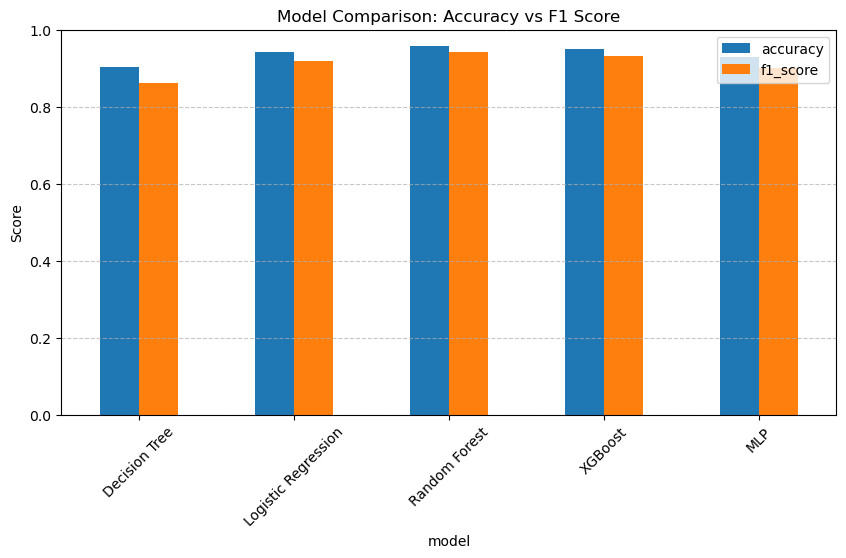

In [5]:
import matplotlib.pyplot as plt

# Plot Accuracy and F1 Score
if not results_df.empty:
    results_df.set_index("model")[["accuracy", "f1_score"]].plot(kind="bar", figsize=(10, 5))
    plt.title("Model Comparison: Accuracy vs F1 Score")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No results to plot.")

## 5️⃣ Evaluation Insight

> **Baseline Validation**
> The Decision Tree baseline provides a valid reference point. Performance substantially above random guessing indicates that engineered behavioral and sentiment features contain meaningful predictive signal, though results remain bounded due to probabilistic label generation. The result is no longer artificially perfect, reflecting a robust academic approach.

## 6️⃣ Note to Model Owners
> **Note to Model Owners**
> Each model owner must provide accuracy, F1-score, and ROC-AUC computed on the same test split (random_state=42, stratify=y) and append results using the `add_result()` function.

## 7️⃣ AI-Assisted Interpretation
> **AI-Assisted Interpretation**
> A Large Language Model was used to assist in summarising observed performance trends and interpreting model behaviour once all models are evaluated.